# Running simulations using Pop2net

In the previous part of this introduction, we have learned how to use Pop2net to build, evaluate and export networks.
In the following part of this introduction, we will learn how to use Pop2net to directly run a simulation based on the defined network.
In this simple simulation example, we do not use any additional package to run the simulation, but only Pop2net.
However, it is possible (and recommended) to use Pop2net in combination with a dedicated simulation framework, like Mesa or AgentPy.
See chapter *Integration into ABM frameworks* for examples of how to integrate Pop2net into Mesa and ActorPy.

In the following, we programme a simple infection simulation as an example of how to use pop2net to run simulations.

In [1]:
# this is a hidden cell which sets seeds for consistent outputs

import random

import numpy as np

random.seed(0)
np.random.seed(0)

## DataFaker

In the previous example, we used example data to create the population of actors.
In this example, we also use *fake* data, but this time we use a data generator provided by Pop2net to generate the data.
The DataFaker creates a data set of any size, which is similar to a classic survey data set.
`pop2net.data_fakers.soep_faker` creates data similiar to the [German Socio-Economic Panel](https://www.diw.de/en/diw_01.c.678568.en/research_data_center_soep.html).

We start by creating a dataset of 1000 rows:

In [2]:
import pop2net as p2n
from pop2net.data_fakers.soep import soep_faker

df_soep = soep_faker.soep(size=1000, seed=1000000)
df_soep.head()

,age,gender,work_hours_day,nace2_division,hid,pid
0,74.0,female,0.000000,-2,1434,2344
1,31.0,female,7.473384,87,1434,695
2,24.0,male,0.396244,1,1434,2077
3,77.0,female,0.000000,-2,5711,346
4,26.0,female,0.000000,-2,5711,5288


## Creating a simulation

Let's start with designing the network by defining 4 location types:
A home `Home`, to which all actors of a household are assigned, a workplace `Work`, which groups the actors according to their occupational sectors, and a school `School`, which contains age-specific classes.
To ensure that each actor has contact with at least two other actors, we also define the location `Ring`, which connects the entire population along a ring.

In [3]:
import networkx as nx


class Home(p2n.LocationDesigner):
    def split(self, actor):
        return actor.hid

    def weight(self, actor):
        return 12


class Work(p2n.LocationDesigner):
    n_actors = 10

    def filter(self, actor):
        return True if actor.work_hours_day > 0 and actor.nace2_division > 0 else False

    def split(self, actor):
        return actor.nace2_division

    def weight(self, actor):
        return actor.work_hours_day


class School(p2n.LocationDesigner):
    n_actors = 25

    def filter(self, actor):
        return True if 6 <= actor.age <= 18 else False

    def split(self, actor):
        return actor.age

    def weight(self, actor):
        return 6


class Ring(p2n.LocationDesigner):
    def setup(self):
        self.nxgraph = nx.cycle_graph(n=len(self.model.env.actors))

Next, we create our actor class with the attributes `infection_status` and `days_since_infection` as well as the methods `infect` and `update_infection_status`.

What is relevant here is how the actor accesses other actors with which it is in contact.
This is done using the `actor.neighbors()` method.
On the other hand, it is relevant how the actor determines *how much* contact it has or has had with the other actors.
This is done using the method `actor.get_actor_weight()`.
Both methods include all locations that an actor visits.

In [4]:
import random


class Actor(p2n.Actor):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.infection_status = "susceptible"
        self.days_since_infection = 0

    def infect(self):
        if self.infection_status in ["infectious", "symptomatic"]:
            for actor_v in self.neighbors():
                if actor_v.infection_status == "susceptible":
                    infection_probability = 0.01 * self.get_actor_weight(actor_v)

                    if random.random() < infection_probability:
                        actor_v.infection_status = "exposed"

    def update_infection_status(self):
        if self.infection_status in ["exposed", "infectious", "symptomatic"]:
            self.days_since_infection += 1

            if 2 <= self.days_since_infection <= 5:
                self.infection_status = "infectious"

            elif 6 <= self.days_since_infection <= 10:
                self.infection_status = "symptomatic"

            elif self.days_since_infection >= 11:
                self.infection_status = "recovered"

Next, we define the simulation model.
In the `__init__()` method we initialize environment and creator objects and some lists to save the data.
Subsequently, we create the network and infect 10 randomly chosen agents.

In `step()` we define what should happen in each individual time step of the simulation.
First, the method `update_infection_status()` is to be executed for each actor and then the method `infect()` for each actor.
Afterwards, we collect the number of actors ever infected per time step in order to visualize it after the simulation.

The method `run` just executes the method `step` for a specific amount of steps.

In [5]:
class InfectionModel:
    def __init__(self):
        self.env = p2n.Environment(model=self)
        self.creator = p2n.Creator(env=self.env)
        self.n_infected_actors = []
        self.n_cumulative_infections = []

        # Create actors and locations and add them to the environment
        self.creator.create(
            df=df_soep,
            actor_class=Actor,
            location_designers=[
                Home,
                Work,
                School,
                Ring,
            ],
        )

        # infect 10 random actors
        for actor in random.choices(self.env.actors, k=10):
            actor.infection_status = "exposed"

        self.inspector = p2n.NetworkInspector(env=self.env)

    def step(self):
        for actor in self.env.actors:
            actor.update_infection_status()

        for actor in self.env.actors:
            actor.infect()

        n_currently_infected_actors = sum(
            [
                1
                for actor in self.env.actors
                if actor.infection_status in ["infectious", "symptomatic"]
            ]
        )
        self.n_infected_actors.append(n_currently_infected_actors)
        self.n_cumulative_infections.append(
            sum([1 for agent in self.env.actors if agent.infection_status != "susceptible"])
        )

    def run(self, steps=1):
        for s in range(steps):
            self.step()

Let's execute the model:

In [6]:
model = InfectionModel()
results = model.run(steps=50)

Below, you can see the number of infections per time step.

Text(0, 0.5, 'Infections')

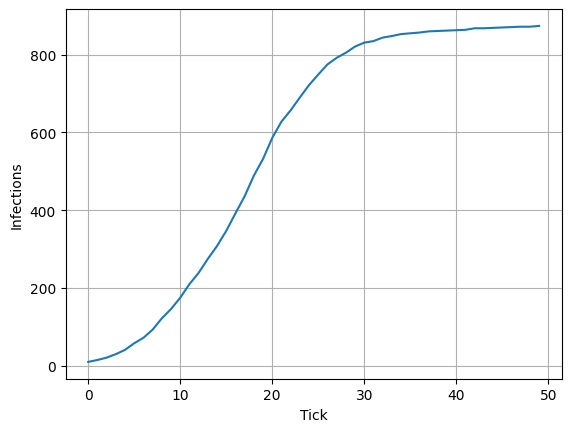

In [7]:
import matplotlib.pyplot as plt

data1 = model.n_cumulative_infections
plt.plot(data1)
plt.grid()
plt.xlabel("Tick")
plt.ylabel("Infections")

Just because we can, let's have look at the network:

In [8]:
model.inspector.plot_bipartite_network()

In [9]:
model.inspector.plot_actor_network()

## Simulations on dynamic networks

Up to now, we have had purely static networks that have not changed once they have been created.
In pop2net, there are two ways to change the networks during the simulation.
Firstly, actors can leave and join locations using the location methods `remove_actor()` and `add_actor()`, for instance.
If a complete *move* of the actor from one location to another is not necessary, the connection weights between the actor and the location can also simply be varied.
In the following, we will have a look at this method to create dynamic networks.

We now want to add another property to the infection simulation: Actors only visit the school or workplace if they are not currently symptomatically ill.
In order to exclude actors who are symptomatically ill from schools and workplaces, we adapt the `weight()` method in each case.
As the weights can now change in every time step, we have to make sure that the weights are updated in every time step.
Therefore we add the line `self.env.update_weights(location_labels=["Home", "School", "Work"])` to `InfectionModel.step()` which updates the edge weights between all actors and locations of the types `Home`, `School` and `Work` in every time step.

In [10]:
class Home(p2n.LocationDesigner):
    def split(self, actor):
        return actor.hid

    def weight(self, actor):
        if actor.infection_status == "symptomatic":
            return 3
        else:
            return 12


class Work(p2n.LocationDesigner):
    n_actors = 10

    def filter(self, actor):
        return True if actor.work_hours_day > 0 and actor.nace2_division > 0 else False

    def split(self, actor):
        return actor.nace2_division

    def weight(self, actor):
        if actor.infection_status == "symptomatic":
            return 0
        else:
            return actor.work_hours_day


class School(p2n.LocationDesigner):
    n_actors = 25

    def filter(self, actor):
        return True if 6 <= actor.age <= 18 else False

    def split(self, actor):
        return actor.age

    def weight(self, actor):
        if actor.infection_status == "symptomatic":
            return 0
        else:
            return 6


class Ring(p2n.LocationDesigner):
    def setup(self):
        self.nxgraph = nx.cycle_graph(n=len(self.model.env.actors))

In [11]:
class InfectionModel:
    def __init__(self):
        self.env = p2n.Environment(model=self)
        self.creator = p2n.Creator(env=self.env)
        self.n_infected_actors = []
        self.n_cumulative_infections = []

        # Create actors and locations and add them to the environment
        self.creator.create(
            df=df_soep,
            actor_class=Actor,
            location_designers=[
                Home,
                Work,
                School,
                Ring,
            ],
        )

        # infect 10 random actors
        for actor in random.choices(self.env.actors, k=10):
            actor.infection_status = "exposed"

        self.inspector = p2n.NetworkInspector(env=self.env)

    def step(self):
        self.env.update_weights(location_labels=["Home", "School", "Work"])

        for actor in self.env.actors:
            actor.update_infection_status()

        for actor in self.env.actors:
            actor.infect()

        n_currently_infected_actors = sum(
            [
                1
                for actor in self.env.actors
                if actor.infection_status in ["infectious", "symptomatic"]
            ]
        )
        self.n_infected_actors.append(n_currently_infected_actors)

        self.n_cumulative_infections.append(
            sum([1 for agent in self.env.actors if agent.infection_status != "susceptible"])
        )

    def run(self, steps=1):
        for s in range(steps):
            self.step()

In [12]:
class Actor(p2n.Actor):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.infection_status = "susceptible"
        self.days_since_infection = 0

    def infect(self):
        if self.infection_status in ["infectious", "symptomatic"]:
            for actor_v in self.neighbors():
                if actor_v.infection_status == "susceptible":
                    contact_weight = self.get_actor_weight(actor_v)
                    infection_probability = 0.01 * contact_weight

                    if random.random() < infection_probability:
                        actor_v.infection_status = "exposed"

    def update_infection_status(self):
        if self.infection_status in ["exposed", "infectious", "symptomatic"]:
            self.days_since_infection += 1

            if 1 <= self.days_since_infection <= 2:
                self.infection_status = "infectious"

            elif 3 <= self.days_since_infection <= 10:
                self.infection_status = "symptomatic"

            elif self.days_since_infection >= 11:
                self.infection_status = "recovered"

In [13]:
model = InfectionModel()
results = model.run(steps=50)

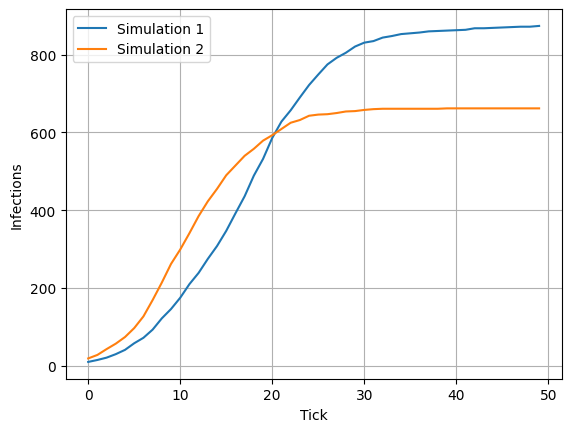

In [14]:
data2 = model.n_cumulative_infections

plt.plot(data1, label="Simulation 1")
plt.plot(data2, label="Simulation 2")
plt.xlabel("Tick")
plt.ylabel("Infections")
plt.legend()
plt.grid()